In [ ]:
import os
os.environ["JAX_ENABLE_X64"] = "true"

import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from nrmifactors import algorithm as algo
from nrmifactors.state import State
import nrmifactors.priors as priors

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [2]:
ndata = 500

key = random.PRNGKey(0)

means = np.array([-10.0, -3.0, 3.0, 10.0])

probas = np.vstack(
    [np.ones(4),
     np.array([0, 1, 0, 1]),
     np.array([1, 0, 1, 0]),
     np.array([0, 0, 1, 1]),
     np.array([1, 1, 0, 0]),
     np.array([0, 0.2, 0, 0.8]),
     np.array([0.7, 0.3, 0, 0])]
)

probas = np.vstack(
    [np.ones(4),
     np.array([0.0, 1.0, 0.0, 1.0]),
     np.array([1.0, 0.0, 1.0, 0.0]),
     np.array([0.0, 0.1, 0.0, 0.9]),
     np.array([0.9, 0.0, 0.1, 0.0]),
     np.array([1.0, 0.0, 0.0, 0.0])
    ]
)

ngroups = probas.shape[0]

probas = probas / probas.sum(axis=1)[:, np.newaxis]

key, subkey = random.split(key)
clus = tfd.Categorical(probs=probas).sample((ndata), seed=subkey).T
data = tfd.Normal(means[clus], np.ones_like(clus, dtype=float)).sample(seed=subkey)

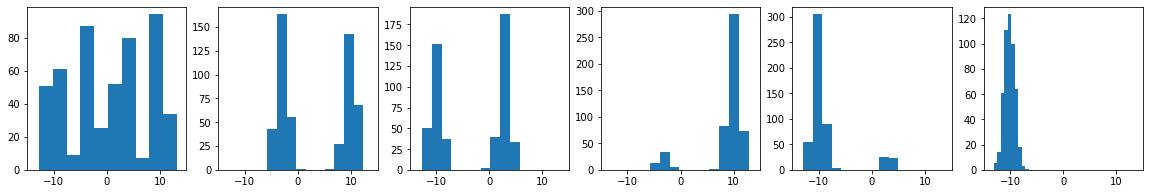

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 3))
for i in range(ngroups):
    axes[i].hist(onp.array(data[i, :]))
    axes[i].set_xlim(-15, 15)

In [4]:
from sklearn.cluster import KMeans

natoms = 10
nlat = 2

# initialize stuff
# init_atoms = np.hstack([
#    tfd.Normal(loc=0, scale=10).sample(natoms, seed=key).reshape(-1, 1),
#    np.ones((natoms, 1))
# ])

km = KMeans(natoms)
km.fit(data.reshape(-1, 1))
clus = km.predict(data.reshape(-1,1)).reshape(data.shape)
means = km.cluster_centers_

init_atoms = np.hstack([means, np.ones_like(means) * 0.3])

In [5]:
init_atoms

DeviceArray([[  8.65753975,   0.3       ],
             [ -8.71776649,   0.3       ],
             [  2.39530784,   0.3       ],
             [ -2.18167664,   0.3       ],
             [ -9.99372787,   0.3       ],
             [  9.92157488,   0.3       ],
             [ -3.84389217,   0.3       ],
             [-11.17864241,   0.3       ],
             [  3.86306644,   0.3       ],
             [ 11.14178817,   0.3       ]], dtype=float64)

In [6]:
def get_lambda_mgp(phis, deltas):
    taus = np.cumprod(deltas, axis=-1)
    out = 1.0 / (phis * taus)
    return out


def simulate_mgp(key, nu, a1, a2):
    key, subkey = random.split(key)
    deltas = np.concatenate([
        tfd.Gamma(a1, 1).sample((1, ), seed=subkey),
        tfd.Gamma(a1, 1).sample((nlat-1, ), seed=subkey)])
    
    key, subkey = random.split(key)
    phis = tfd.Gamma(nu/2, nu/2).sample((ngroups, nlat), seed=subkey)
    return get_lambda_mgp(phis, deltas)

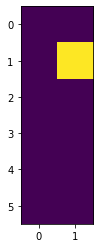

In [7]:
plt.imshow(simulate_mgp(key, 1, 2, 3))

In [8]:
#init_atoms = np.hstack([means.reshape(-1, 1), np.ones_like(means).reshape(-1, 1) * 1])
#natoms = init_atoms.shape[0]

prior = priors.NrmiFacPrior(
    kern_prior=priors.NNIGPrior(0.0, 0.01, 5.0, 5.0),
    lam_prior_iid=priors.GammaPrior(2.0, 2.0),
    lam_prior_mgp=priors.MGPPrior(100.0, 2.0, 3.0, 0, -0.05, 0.01),
    lam_prior="mgp",
    m_prior=priors.GammaPrior(2.0, 2.0),
    j_prior=priors.GammaPrior(2.0, 2.0))


lam = simulate_mgp(key, 5, 2, 3)
#m = np.hstack([np.eye(nlat) * 5 + 0.5, np.zeros((nlat, natoms - nlat)) + 0.5])
m = tfd.Gamma(prior.m_prior.a, prior.m_prior.b).sample((nlat, natoms), seed=key).astype(float)


j = np.ones(natoms).astype(float) * 0.5
u = np.ones(ngroups).astype(float)

#clus = tfd.Categorical(probs=np.ones(natoms)/natoms).sample(data.shape, seed=key)
state = State(
    iter=0,
    atoms=init_atoms, 
    j=j, 
    lam=lam,
    phis=1.0/lam,
    deltas=np.ones(lam.shape[1]),
    m=m, 
    clus=clus, 
    u=u,
)
nan_idx = np.where(np.isnan(data))
nobs_by_group = np.array(
        [np.count_nonzero(~np.isnan(x)) for x in data]).astype(float)

In [9]:
np.linalg.norm(lam, axis=0) > 0.5

DeviceArray([ True,  True], dtype=bool)

In [10]:
key = random.PRNGKey(202204)

In [11]:
from copy import deepcopy

states = [deepcopy(state)]
for i in range(30):
    print("\r{0}/{1}".format(i+1, 100), flush=True, end=" ")
    state, key = algo.run_one_adapt_step(state, data, nan_idx, nobs_by_group, prior, key)
    states.append(deepcopy(state))

1/100 

adding column


2/100 

adding column


3/100 

adding column


4/100 

adding column


5/100 

removing cols


6/100 

removing cols


7/100 

adding column


8/100 

removing cols


9/100 

adding column


10/100 

removing cols


11/100 

12/100 

adding column


13/100 

removing cols


14/100 

15/100 

16/100 

17/100 

18/100 

19/100 

20/100 

21/100 

adding column


22/100 

removing cols


23/100 

24/100 

adding column


25/100 

26/100 

27/100 

adding column


28/100 

29/100 

30/100 

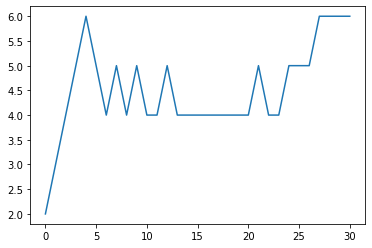

In [12]:
plt.plot([x.lam.shape[1] for x in states])

In [ ]:
np.median(norms) * 0.01

In [ ]:
norms

In [ ]:
norms = np.linalg.norm(states[-2].lam, axis=0)
norms > 0.05 * np.median(norms)

In [23]:
from copy import deepcopy

niter = 10000
nburn = 5000
thin = 1

state = states[-1]


for i in range(niter):
    print("\r{0}/{1}".format(i+1, niter), flush=True, end=" ")
    state, key = algo.run_one_step(state, data, nan_idx, nobs_by_group, prior, key)
    if (i > nburn) and (i % thin == 0):
        states.append(deepcopy(state))

10000/10000               

In [24]:
import pickle


# with open("simulation1_chains_mgp.pickle", "wb") as fp:
#     pickle.dump(states, fp)

In [1]:
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

In [2]:
xgrid = np.linspace(-15, 15, 1000)

fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

idx = [-1, -10, -1000]

for i in range(ngroups):
    axes[i].hist(onp.array(data[i, :]), density=True, alpha=0.3, bins="doane")

for j in sorted(idx):

    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in range(ngroups):
        axes[i].plot(xgrid, dens[i, :], label="j: {0}".format(j))
        axes[i].set_xlim(-15, 15)
        
axes[0].legend(fontsize=12)   
plt.tight_layout()
# plt.savefig("simu1/dens_estimate.pdf", bbox_inches="tight")        
plt.show()

NameError: name 'np' is not defined

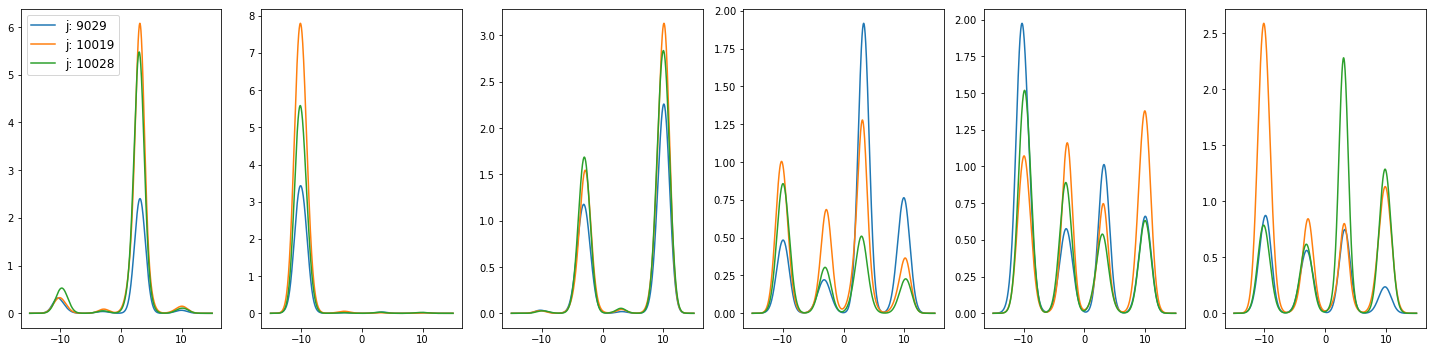

In [27]:
nlat = states[-1].lam.shape[1]

fig, axes = plt.subplots(nrows=1, ncols=int(nlat), figsize=(20, 5))
axes = axes.flat

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], label="j: {0}".format(len(states) + j))
        
axes[0].legend(fontsize=12)

plt.tight_layout()
plt.show()

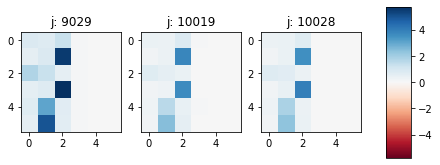

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=len(idx), figsize=(7, 3))

idx = sorted(idx)

lambs = np.array([states[i].lam for i in idx])
vmax = np.max(lambs)

for i in range(len(idx)):
    lam = states[idx[i]].lam
    im = axes[i].imshow(lam, vmax=vmax, vmin=-vmax, cmap="RdBu")
    axes[i].set_title("j: {0}".format(len(states) + idx[i]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)    

# plt.savefig("simu1/lambdas.pdf", bbox_inches="tight")

plt.show()

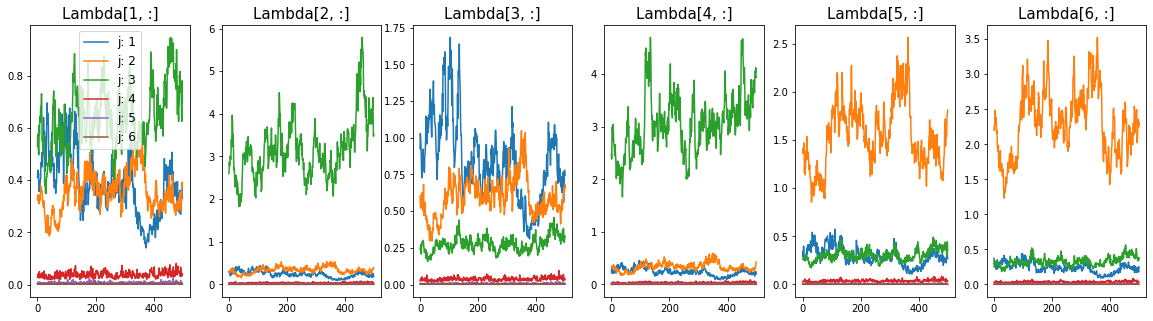

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

def get_lambda_mgp(phis, deltas):
    taus = np.cumprod(deltas, axis=-1)
    out = 1.0 / (phis * taus)
    return out

for i in range(ngroups):
    for j in range(nlat):
        axes[i].plot([x.lam[i, j] for x in states[-500:]], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Lambda[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

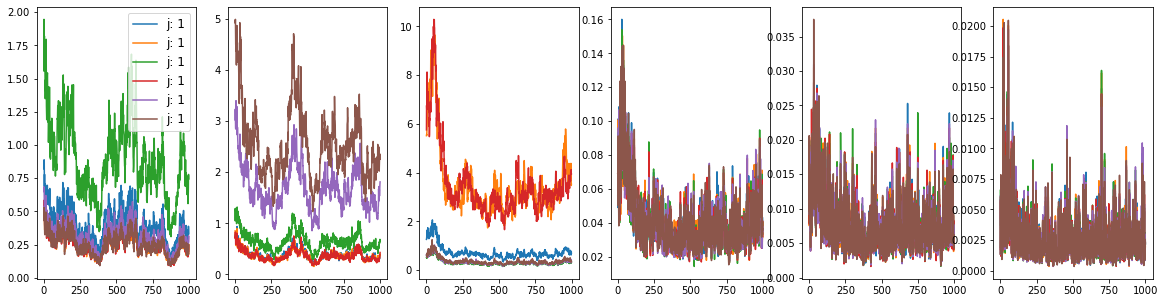

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(20,5))

axes = axes.flat


for i in range(ngroups):
    for j in range(nlat):
        axes[j].plot([x.lam[i, j] for x in states[-1000:]], label="j: {0}".format(j + 1))
    

axes[0].legend(fontsize=12)

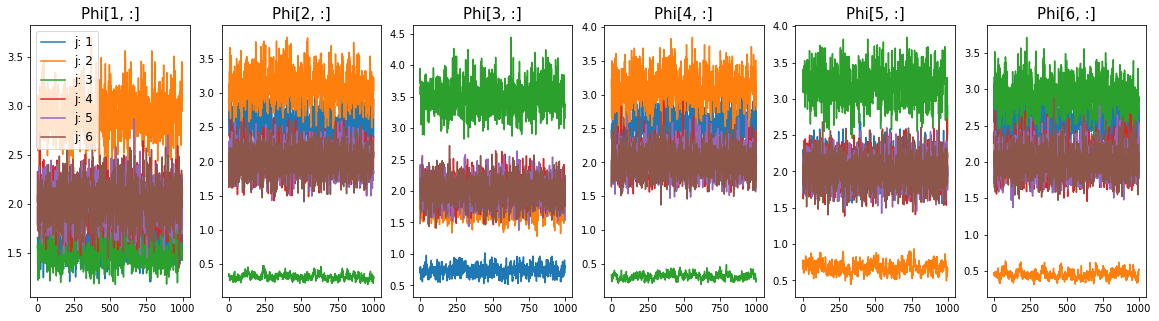

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

for i in range(ngroups):
    for j in range(nlat):
        axes[i].plot([x.phis[i, j] for x in states[-1000:]], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Phi[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

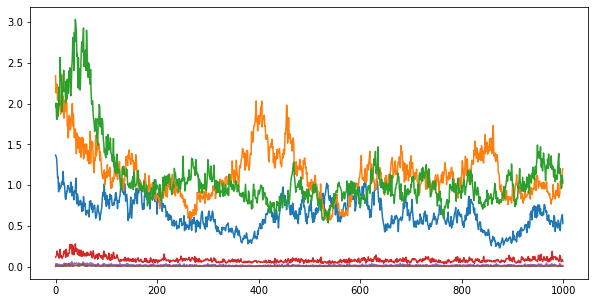

In [32]:
fig = plt.figure(figsize=(10, 5))

deltachain = np.stack([x.deltas for x in states[-1000:]])
tauchain = np.cumprod(deltachain, axis=-1)

for j in range(nlat):
    plt.plot(1.0 / tauchain[:, j], label="j: {0}".format(j + 1))

axes[0].legend(fontsize=12)

In [33]:
def get_lambda_mgp(phis, deltas):
    taus = np.cumprod(deltas, axis=-1)
    out = 1.0 / (phis * taus)
    return out

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=int(nlat / 4), figsize=(20, 20))
axes = axes.flat

for i in range(nlat):
    for j in range(natoms):
        axes[i].plot([x.m[i, j] for x in states[100:]], label="j: {0}".format(j))
    axes[i].set_title("M[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

In [ ]:
for j in range(3):
    plt.plot([x.j[j] for x in states[100:]], label="j: {0}".format(1))

In [ ]:
xgrid = np.linspace(0, 10, 100)

nu = 10
plt.plot(xgrid, tfd.Gamma(nu, nu/2).log_prob(xgrid))

In [ ]:
def mgp_prior(phis, deltas, nu, a1, a2):
        out = np.sum(tfd.Gamma(
            nu, nu/2,
            force_probs_to_zero_outside_support=True).log_prob(phis))
        out += tfd.Gamma(
            a1, 1,
            force_probs_to_zero_outside_support=True).log_prob(deltas[0])
        out += np.sum(tfd.Gamma(
            a2, 1,
            force_probs_to_zero_outside_support=True).log_prob(deltas[1:]))
        return out

def full_cond_lpdf(phis_deltas, cluscount):
    phis, deltas = phidelta_fromvec(phis_deltas)
    lam = get_lambda_mgp(phis, deltas)
    lm = np.matmul(lam, m)
    out = mgp_prior(phis, deltas, mgp_nu, mgp_a1, mgp_a2) + \
          np.sum(np.log(lm) * cluscount) - np.sum(np.sum(lm * j, axis=1) * u)
    return out

In [ ]:
mgp_prior(states[-1].phis, states[-1].deltas, 10000, 2, 2)

In [ ]:
nu = 10000
np.sum(tfd.Gamma(
    nu, nu/2,
    force_probs_to_zero_outside_support=True).log_prob(states[-1].phis))